In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Question 1.2

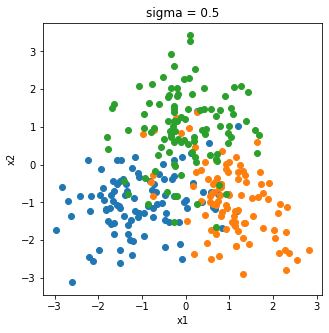

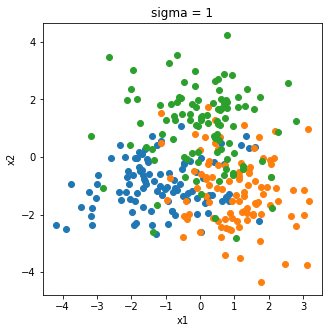

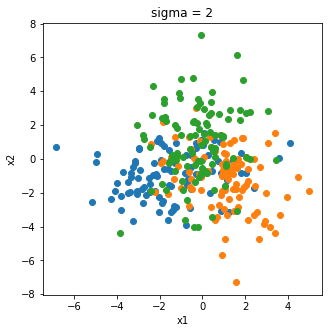

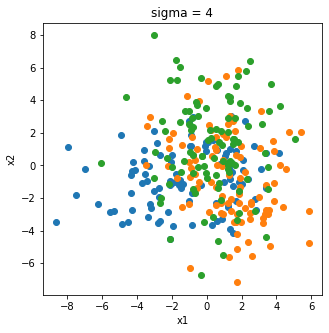

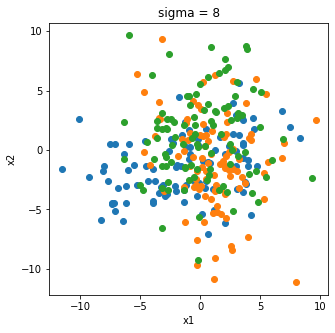

In [2]:
# Create data
means_arr = [np.array([-1,-1]), np.array([1,-1]), np.array([0,1])] # {a->0,b->1,c->2}
cov_arr = [np.array([[2,0.5],[0.5,1]]), np.array([[1,-0.5],[-0.5,2]]), np.array([[1,0],[0,2]])]

def create_data(sigma, plot=False):
    mean_a = np.array([-1,-1])
    cov_a = sigma*np.array([[2,0.5],[0.5,1]])

    mean_b = np.array([1,-1])
    cov_b = sigma*np.array([[1,-0.5],[-0.5,2]])

    mean_c = np.array([0,1])
    cov_c = sigma*np.array([[1,0],[0,2]])

    X1 = np.random.multivariate_normal(mean_a, cov_a, 100)
    X2 = np.random.multivariate_normal(mean_b, cov_b, 100)
    X3 = np.random.multivariate_normal(mean_c, cov_c, 100)

    X = np.concatenate((X1,X2,X3), axis=0)
    if plot:
        plt.figure(figsize=(5,5))
        plt.scatter(X1[:,0], X1[:,1])
        plt.scatter(X2[:,0], X2[:,1])
        plt.scatter(X3[:,0], X3[:,1])
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title(f'sigma = {sigma}')
        plt.show()
    return X


sigma_arr = [0.5,1,2,4,8]
X_arr = []
Y = np.concatenate((0*np.ones(100), 1*np.ones(100), 2*np.ones(100)), axis=0)
for sigma in sigma_arr:
    X_arr.append(create_data(sigma, plot=True))


In [26]:
# K-means
def kMeans(X, k, max_iters=100):
    # Initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    prev_centroids = np.zeros_like(centroids)
    for i in range(max_iters):
        # Assign each data point to the closest centroid
        dist = np.linalg.norm(X[:,None]-centroids, axis=2)
        labels = np.argmin(dist, axis=1)
        # Update centroids
        for j in range(k):
            centroids[j] = np.mean(X[labels==j], axis=0)
            
        # Check for convergence
        converged = np.allclose(centroids, prev_centroids)
        if converged:
            print("Converged!")
            break
    return centroids, labels


# plot clusters
def plot_clusters(X, centroids, labels):
    plt.figure(figsize=(5,5))
    plt.scatter(X[labels==0][:,0], X[labels==0][:,1])
    plt.scatter(X[labels==1][:,0], X[labels==1][:,1])
    plt.scatter(X[labels==2][:,0], X[labels==2][:,1])
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=100, c='k')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    
centroids, labels = kMeans(X_arr[0], 3, max_iters=100)


def kmeans_acc(X,labels):
    mean0 = np.mean(X[labels == 0,:],axis=0) # mean of cluster 0
    mean1 = np.mean(X[labels == 1,:],axis=0) # mean of cluster 1
    mean2 = np.mean(X[labels == 2,:],axis=0) # mean of cluster 2

    # find closest mean from means_arr to mean0
    dist = np.linalg.norm(means_arr - mean0, axis=1)
    label0 = np.argmin(dist)
    # find closest mean from means_arr to mean1
    dist = np.linalg.norm(means_arr - mean1, axis=1)
    label1 = np.argmin(dist)
    # find closest mean from means_arr to mean2
    dist = np.linalg.norm(means_arr - mean2, axis=1)
    label2 = np.argmin(dist)

    # map labels to clusters
    y_pred = -1*np.ones_like(labels)
    y_pred[labels == 0] = label0
    y_pred[labels == 1] = label1
    y_pred[labels == 2] = label2 

    # calculate accuracy
    acc = np.sum(y_pred == Y)/len(Y)
    print(f'Accuracy = {acc}')
    
    return acc
    
# compute kmeans clustering objective
def kmeans_obj(X, centroids, labels):
    obj = 0
    for i in range(len(X)):
        obj += np.linalg.norm(X[i]-centroids[labels[i]])**2
    return obj


SyntaxError: invalid syntax (2254930689.py, line 71)

In [42]:
def gmm_em(data, num_components, num_iterations):
    num_points, num_features = data.shape

    # Initialize the parameters
    np.random.seed(0)  # for reproducibility
    means = np.random.rand(num_components, num_features)
    covariances = np.array([np.eye(num_features) for _ in range(num_components)])
    pis = np.ones(num_components) / num_components  # mixing coefficients
    
    def gaussian_pdf(x, mean, cov):
        size = len(x)
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), float(size) / 2) * np.sqrt(det_cov))
        x_minus_mu = x - mean
        result = np.exp(-0.5 * (x_minus_mu @ np.linalg.inv(cov) @ x_minus_mu.T))
        return norm_const * result
    
    log_likelihood = 0.0

    for iteration in range(num_iterations):
        # Expectation step
        responsibilities = np.zeros((num_points, num_components))
        for c in range(num_components):
            for p in range(num_points):
                responsibilities[p, c] = pis[c] * gaussian_pdf(data[p], means[c], covariances[c])
        sum_responsibilities = responsibilities.sum(axis=1, keepdims=True)
        log_likelihood_new = np.sum(np.log(sum_responsibilities))
        responsibilities = responsibilities / sum_responsibilities

        # Check for convergence (simple threshold, more complex methods may be used)
        if np.abs(log_likelihood_new - log_likelihood) < 1e-6:
            break
        log_likelihood = log_likelihood_new

        # Maximization step
        Nk = responsibilities.sum(axis=0)
        
        for c in range(num_components):
            # Update means
            means[c] = (1 / Nk[c]) * np.sum(responsibilities[:, c].reshape(num_points, 1) * data, axis=0)
            
            # Update covariances
            diff = data - means[c]
            covariances[c] = (1 / Nk[c]) * np.dot((responsibilities[:, c] * diff.T), diff)
            
            # Update mixing coefficients
            pis[c] = Nk[c] / num_points
    
    # Assign clusters
    cluster_labels = np.argmax(responsibilities, axis=1)
    
    # Return the parameters of the GMM, the cluster labels, and the final log-likelihood
    return means, covariances, pis, cluster_labels, -1*log_likelihood


def gmm_acc(means,labels):
    mean0 = means[0] # mean of cluster 0
    mean1 = means[1] # mean of cluster 1
    mean2 = means[2] # mean of cluster 2

    # find closest mean from means_arr to mean0
    dist = np.linalg.norm(means_arr - mean0, axis=1)
    label0 = np.argmin(dist)
    # find closest mean from means_arr to mean1
    dist = np.linalg.norm(means_arr - mean1, axis=1)
    label1 = np.argmin(dist)
    # find closest mean from means_arr to mean2
    dist = np.linalg.norm(means_arr - mean2, axis=1)
    label2 = np.argmin(dist)

    # map labels to clusters
    y_pred = -1*np.ones_like(labels)
    y_pred[labels == 0] = label0
    y_pred[labels == 1] = label1
    y_pred[labels == 2] = label2 

    # calculate accuracy
    acc = np.sum(y_pred == Y)/len(Y)
    print(f'Accuracy = {acc}')
    
    return acc

In [43]:
means, cov, pis, cluster_labels, ll = gmm_em(X_arr[0], 3,100)

In [51]:
# run kmeans for all sigma values and plot
obj_arr = []
acc_arr = []
gmm_acc_arr = []
gmm_obj_arr = []
for i in range(len(sigma_arr)):
    centroids, labels = kMeans(X_arr[i], 3, max_iters=100)
    obj_arr.append(kmeans_obj(X_arr[i], centroids, labels))
    acc_arr.append(kmeans_acc(X_arr[i], labels))
    means, cov, pis, cluster_labels, ll = gmm_em(X_arr[i], 3,100)
    gmm_obj_arr.append(ll)
    gmm_acc_arr.append(gmm_acc(means, cluster_labels))
    


Accuracy = 0.8233333333333334
Accuracy = 0.82
Accuracy = 0.76
Accuracy = 0.76
Accuracy = 0.6366666666666667
Accuracy = 0.5166666666666667
Accuracy = 0.5366666666666666
Accuracy = 0.53
Accuracy = 0.5033333333333333
Accuracy = 0.48333333333333334


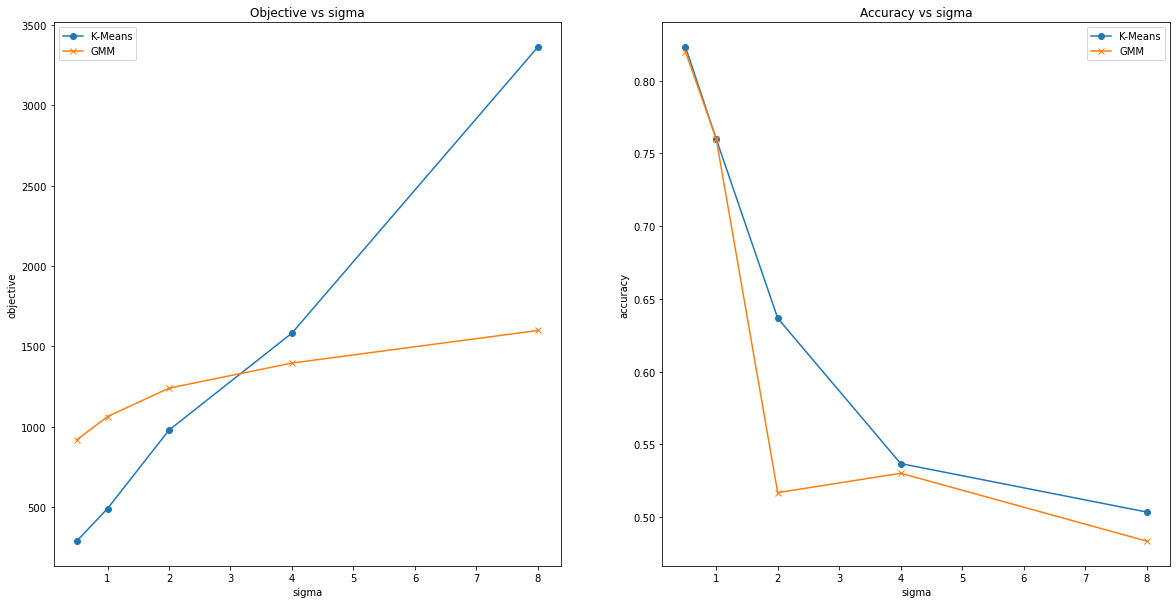

In [52]:
# plot objective vs sigma in subplot
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(sigma_arr, obj_arr, marker='o')
plt.plot(sigma_arr, gmm_obj_arr, marker='x')
plt.legend(['K-Means', 'GMM'])
#plt.xticks(sigma_arr)
plt.xlabel('sigma')
plt.ylabel('objective')
plt.title('Objective vs sigma')

# plot accuracy vs sigma in subplot
plt.subplot(122)
plt.plot(sigma_arr, acc_arr, marker='o')
plt.plot(sigma_arr, gmm_acc_arr, marker='x')
plt.legend(['K-Means', 'GMM'])
plt.xlabel('sigma')
#plt.xticks(sigma_arr)""
plt.ylabel('accuracy')
plt.title('Accuracy vs sigma')
plt.savefig('clustering.png')
plt.show()

## Question 2.3

In [56]:
# Buggy PCA: PCA Applied directly on matrix X

def buggy_pca(X, d):
    # X: n x D matrix
    U,S,VT = np.linalg.svd(X)

    # compute pca
    Sd = np.diag(S[:d])
    Xd = U[:,:d] @ Sd

    # reconstruct
    Xr = Xd @ VT[:d,:]

    # compute error
    error = np.sum((Xr - X)**2)

    return Xd, Xr, error

# demaned_pca: PCA applied to matrix X with mean subtracted along each dimension
def demeaned_pca(X, d):
    # X: n x D matrix
    # compute mean
    X_mean = np.mean(X, axis=0)
    X1 = X - X_mean
    # X: n x D matrix
    U,S,VT = np.linalg.svd(X1)

    # compute pca
    Sd = np.diag(S[:d])
    Xd = U[:,:d] @ Sd

    
    Xr = (Xd @ VT[:d,:]) + X_mean

    # compute error
    error = np.sum((Xr - X)**2)
    return Xd, Xr, error

#normalized_pca: PCA applied to normalized matrix X
def normalized_pca(X, d):
    # X: n x D matrix
    # compute mean
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X1 = (X - X_mean)/X_std
    
    U,S,VT = np.linalg.svd(X1)
    # compute pca
    Sd = np.diag(S[:d])
    Xd = U[:,:d] @ Sd

    # reconstruct
    Xr = (Xd @ VT[:d,:]) 
    Xr = (Xr * X_std) + X_mean

    # compute error
    error = np.sum((Xr - X)**2)

    return Xd, Xr, error


def DRO(X,d):
    # X: n x D matrix
    # compute svd
    b = np.mean(X, axis=0)
    Y = X - b
    U,S,VT = np.linalg.svd(Y)
    
    # get truncated svd
    Ud = U[:,:d]
    Sd = np.diag(S[:d])
    VTd = VT[:d,:]
    
   
    AT = Sd @ VTd
    Z = Ud
    
    Xd = Z
    Xr = Z @ AT + b.reshape(X.shape[1],1).T
    
    # compute error
    error = np.sum((Xr - X)**2)
   

    return Xd, Xr, error



# plot original points and reconstructed points
def plot_points(X, Xr, title):
    plt.figure(figsize=(10,10))
    plt.scatter(X[:,0], X[:,1], label='original', marker='o', c='b')
    plt.scatter(Xr[:,0], Xr[:,1], label='reconstructed', marker='x', c='r')
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.legend()
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()

In [57]:
# read data
X2d = np.loadtxt('data/data2D.csv', delimiter=',')
X1000d = np.loadtxt('data/data1000D.csv', delimiter=',')

Buggy PCA Error:  44.34515418673971
Demeaned PCA Error:  0.5003042814256461
Normalized PCA Error:  2.4736041727385336
DRO Error:  0.5003042814256461


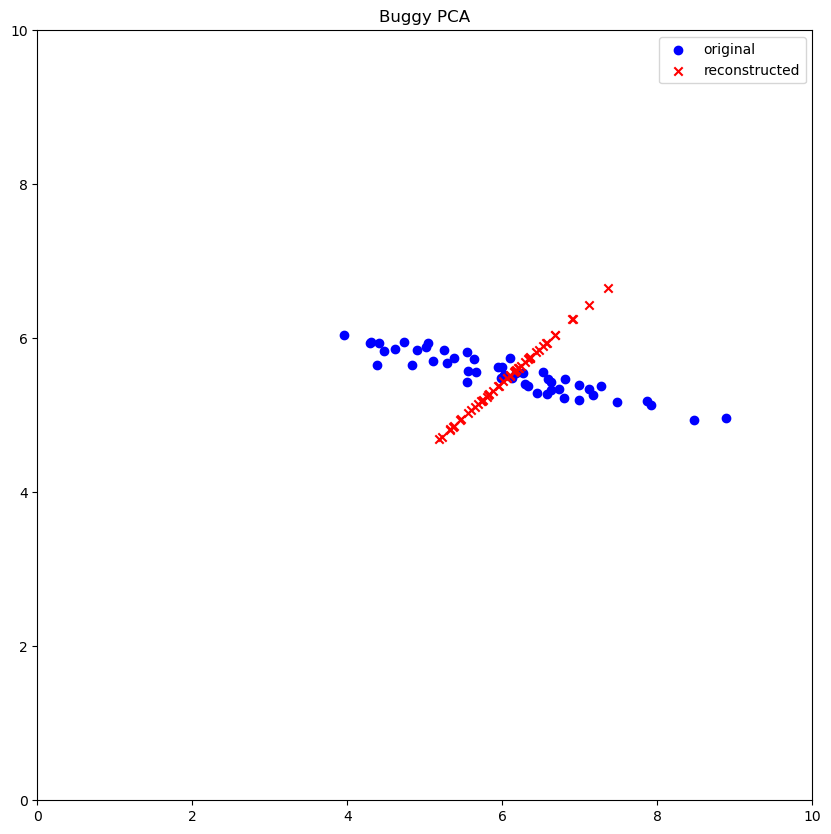

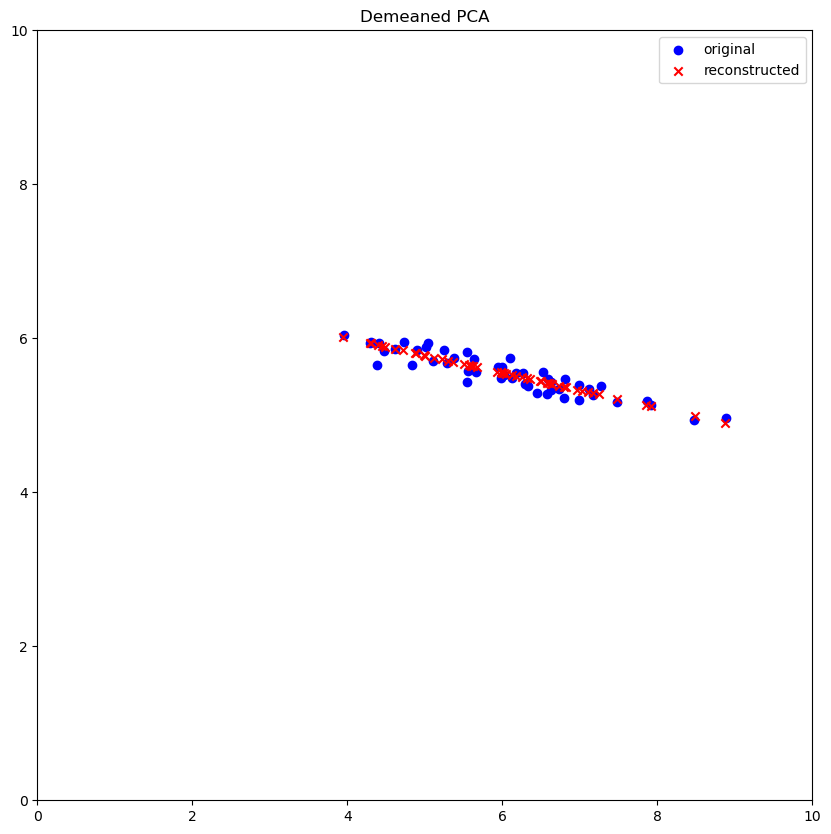

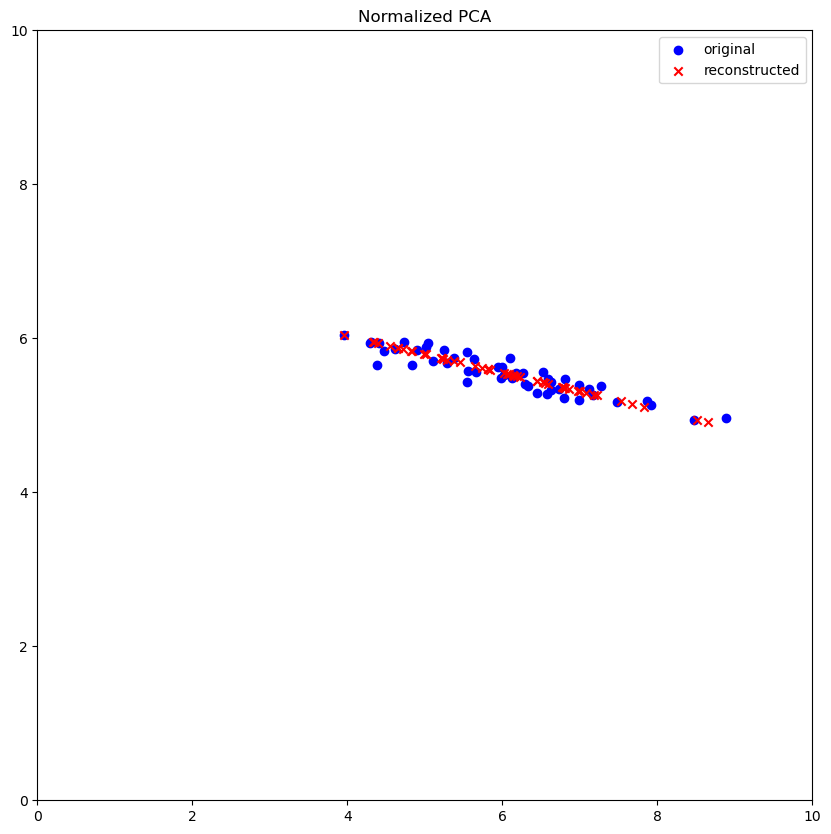

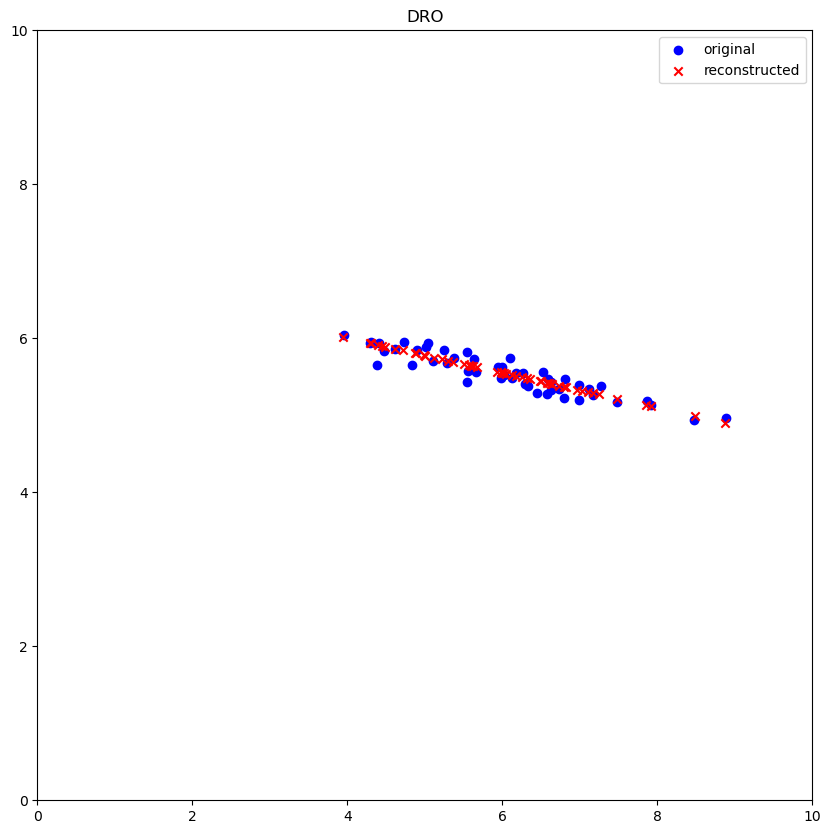

In [58]:
# Experiments on 2D data
d = 1
Xd_buggy, Xr_buggy, error = buggy_pca(X2d, d)
print('Buggy PCA Error: ', error)
Xd_demeaned, Xr_demeaned, error = demeaned_pca(X2d, d)
print('Demeaned PCA Error: ', error)
Xd_norm, Xr_norm, error = normalized_pca(X2d, d)
print('Normalized PCA Error: ', error)
Xd_dro, Xr_dro, error = DRO(X2d, d)
print('DRO Error: ', error)

#plot original points and reconstructed points
plot_points(X2d, Xr_buggy, 'Buggy PCA')
plot_points(X2d, Xr_demeaned, 'Demeaned PCA')
plot_points(X2d, Xr_norm, 'Normalized PCA')
plot_points(X2d, Xr_dro, 'DRO')

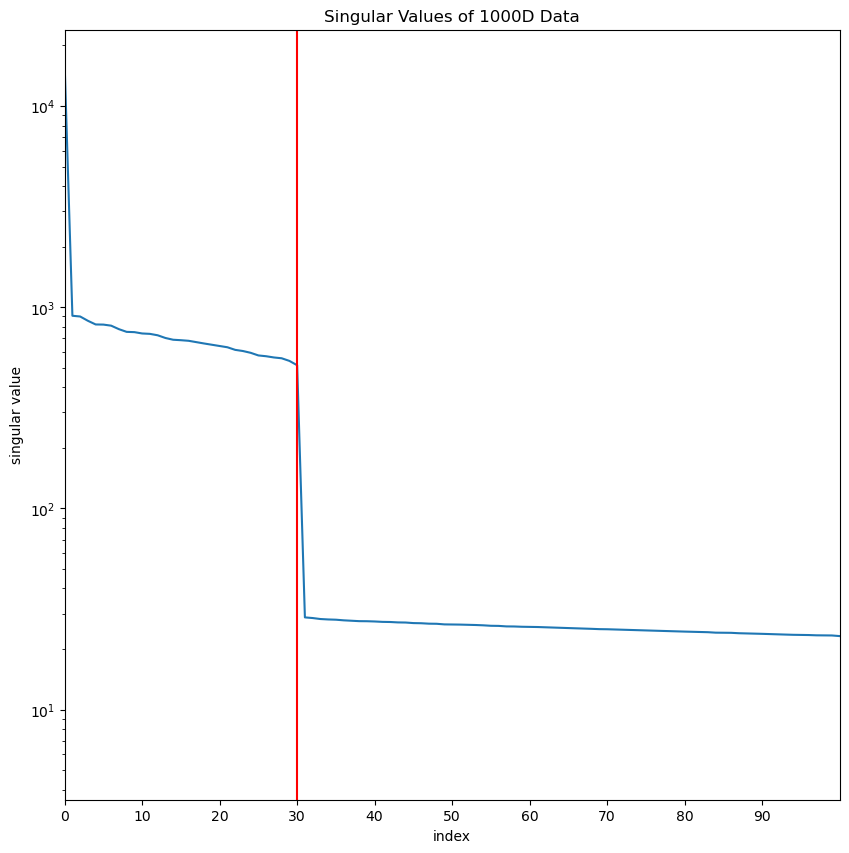

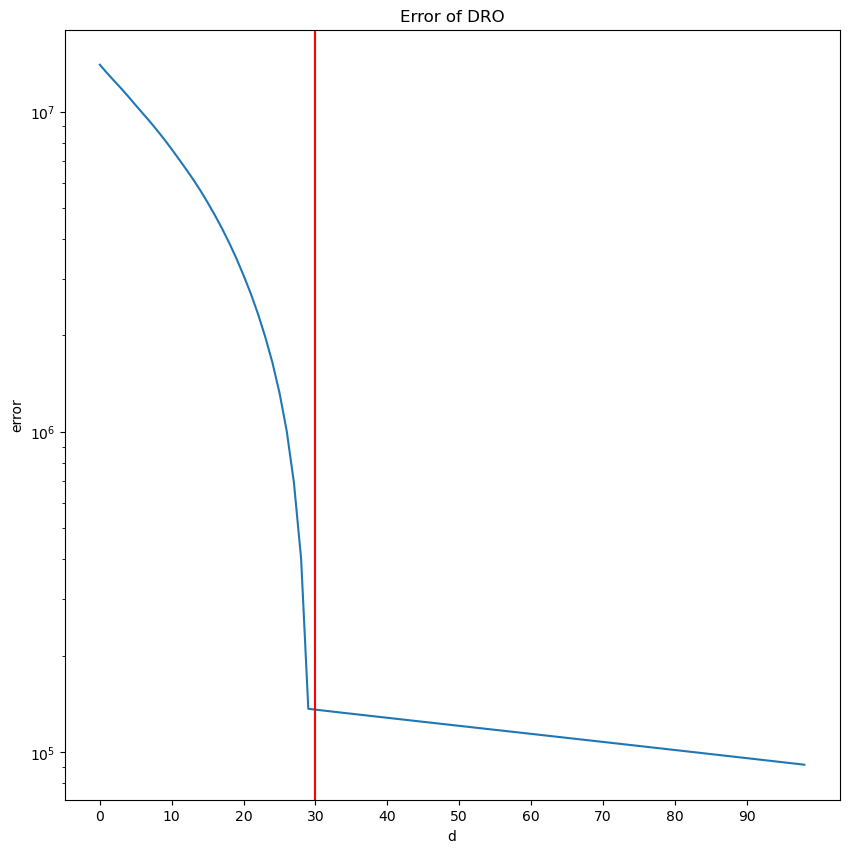

In [84]:
# Experiments on 1000D data

# plot singular values of 1000D data
U,S,VT = np.linalg.svd(X1000d)
plt.figure(figsize=(10,10))
plt.plot(S)
plt.yscale('log')
plt.xlabel('index')
plt.xlim(0,100)
plt.xticks(np.arange(0, 100, 10))
plt.axvline(x=30, c='r')
plt.ylabel('singular value')
plt.title('Singular Values of 1000D Data')
plt.savefig('singular_values.jpg')


# dro for different d
error_dro = []
for d in range(1,100):
    Xd_dro, Xr_dro, error = DRO(X1000d, d)
    error_dro.append(error)
    
# plot error of DRO
plt.figure(figsize=(10,10))
plt.plot(error_dro)
plt.yscale('log')
plt.xlabel('d')
plt.axvline(x=30, c='r')
plt.xticks(np.arange(0, 100, 10))
plt.ylabel('error')
plt.title('Error of DRO')
plt.savefig('error_dro.jpg')




In [88]:
# select best d
d = 31 # knee point

Xd_buggy, Xr_buggy, error = buggy_pca(X1000d, d)
print('Buggy PCA Error: ', error)
Xd_demeaned, Xr_demeaned, error = demeaned_pca(X1000d, d)
print('Demeaned PCA Error: ', error)
Xd_norm, Xr_norm, error = normalized_pca(X1000d, d)
print('Normalized PCA Error: ', error)
Xd_dro, Xr_dro, error = DRO(X1000d, d)
print('DRO Error: ', error)

Buggy PCA Error:  136384.9746109073
Demeaned PCA Error:  135697.80211063704
Normalized PCA Error:  136029.46338770172
DRO Error:  135697.80211063704
